In [192]:
#Imports para descarga y procesamiento de datos
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#Imports modelos y metricas de sklearn 
from sklearn.linear_model import Ridge, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
#Imports modelos y metricas de statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller



df = pd.read_csv("companies.csv")[["Symbol", "Security"]]
###
# No se encontraron datos para los tickers BRK.B y BF.B y por ende se rmeovieron
#['BRK.B']: YFTzMissingError('possibly delisted; no timezone found')
#['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-01-01 -> 2025-01-01)')
###
df.loc[df["Symbol"] == "BRK.B", "Symbol"] = np.nan
df.loc[df["Symbol"] == "BF.B", "Symbol"] = np.nan
df = df.dropna()
tickers=df["Symbol"].to_list()

In [188]:
#SE DESCARGAN LOS DATOS DEL 2015 AL 2025, SIN EMBARGO DEL INICIO DEL 2023 AL INICIO DEL 2025 SOLO SE USARÁN COMO DATOS DE TEST
#ADEMÁS DE ESO SE TOMA EN CUENTA SOLO LA COLUMNA DE CLOSE
#LOS DATOS DESCARGADOS CORRESPONDEN A LA SERIE DE TIEMPO DE CADA STOCK DEL S&P500 Y LA SERIE DEL S&P500 COMO TAL
START_DATE = "2015-01-01"
END_DATE = "2025-01-01"

time_series = yf.download(tickers, start=START_DATE, end=END_DATE, interval="1d", group_by='Ticker',auto_adjust=True)
s_and_p = yf.download(["^GSPC"], start=START_DATE, end=END_DATE, interval="1d", group_by="Ticker", auto_adjust=True)

[*********************100%***********************]  501 of 501 completed
[*********************100%***********************]  1 of 1 completed


In [189]:
for ticker in tickers:
    time_series[ticker, "Log-Returns"] = np.log(time_series[ticker]["Close"]) - np.log(time_series[ticker]["Close"].shift(1))
    time_series[ticker, "Log-Returns_t-1"] = time_series[ticker]["Log-Returns"].shift(1)
    time_series[ticker, "Log-Returns_t-2"] = time_series[ticker]["Log-Returns"].shift(2)
    time_series[ticker, "Log-Returns_t-3"] = time_series[ticker]["Log-Returns"].shift(3)
    time_series[ticker, "Volume-Change"] = np.log(time_series[ticker]["Volume"]) - np.log(time_series[ticker]["Volume"]).shift(1)
    time_series[ticker, "High-Low-Spread"] = (time_series[ticker]["High"] - time_series[ticker]["Low"]) / time_series[ticker]["Close"]

s_and_p = np.log(s_and_p["^GSPC"]["Close"]) - np.log(s_and_p["^GSPC"]["Close"]).shift(1)
time_series = time_series.sort_index(axis=1)

C:\Users\USER\AppData\Local\Temp\ipykernel_16884\3561259753.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_series[ticker, "Log-Returns"] = np.log(time_series[ticker]["Close"]) - np.log(time_series[ticker]["Close"].shift(1))
C:\Users\USER\AppData\Local\Temp\ipykernel_16884\3561259753.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  time_series[ticker, "Log-Returns_t-1"] = time_series[ticker]["Log-Returns"].shift(1)
C:\Users\USER\AppData\Local\Temp\ipykernel_16884\3561259753.py:4: PerformanceWarning: DataFrame is high

### Preparación de Datos

In [190]:
features = ["Log-Returns_t-1","Log-Returns_t-2","Log-Returns_t-3","Volume-Change", "High-Low-Spread"]
nan_percentage = time_series.isna().sum() / len(time_series)
worth_columns = nan_percentage[nan_percentage < 0.3].index

X = time_series[worth_columns]

X = X.loc[:, pd.IndexSlice[:, features]]
X = X.sort_index(axis=1)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()
y = s_and_p.dropna()

#Se alinean los dataframes para que compartan las mismas fechas
y, X = y.align(X, join="inner")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [5]:
estacionareidad = adfuller(y)
print("ADF Statistic:", estacionareidad[0])
print("p-value:", estacionareidad[1])

ADF Statistic: -13.578770240045777
p-value: 2.143957240674517e-25


### Modelo lineal (Ridge)

In [163]:
##Expanding Window para hallar el mejor alpha para Ridge

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
alphas = np.logspace(-3, 3, 100)
tscv = TimeSeriesSplit(n_splits=5)

param_grid = {'alpha': alphas}
ridge = Ridge()

grid = GridSearchCV(
    ridge, 
    param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_alpha = grid.best_params_['alpha']
print(f"Mejor alpha: {best_alpha}")

Mejor alpha: 432.87612810830615


In [169]:
model = Ridge(alpha=best_alpha)
model.fit(X_train, y_train)
y_pred_train = model.predict(X_train)
y_pred = model.predict(X_test)

print(f"TRAIN - MSE: {mean_squared_error(y_train, y_pred_train):.6f}, "
      f"R²: {r2_score(y_train, y_pred_train):.4f}, MAE: {mean_absolute_error(y_train, y_pred_train)}")
print(f"TEST  - MSE: {mean_squared_error(y_test, y_pred):.6f}, "
      f"R²: {r2_score(y_test, y_pred):.4f}, MAE: {mean_absolute_error(y_test, y_pred)}")


TRAIN - MSE: 0.000135, R²: 0.1841, MAE: 0.007522234051277372
TEST  - MSE: 0.000064, R²: -0.0727, MAE: 0.006178389029178965


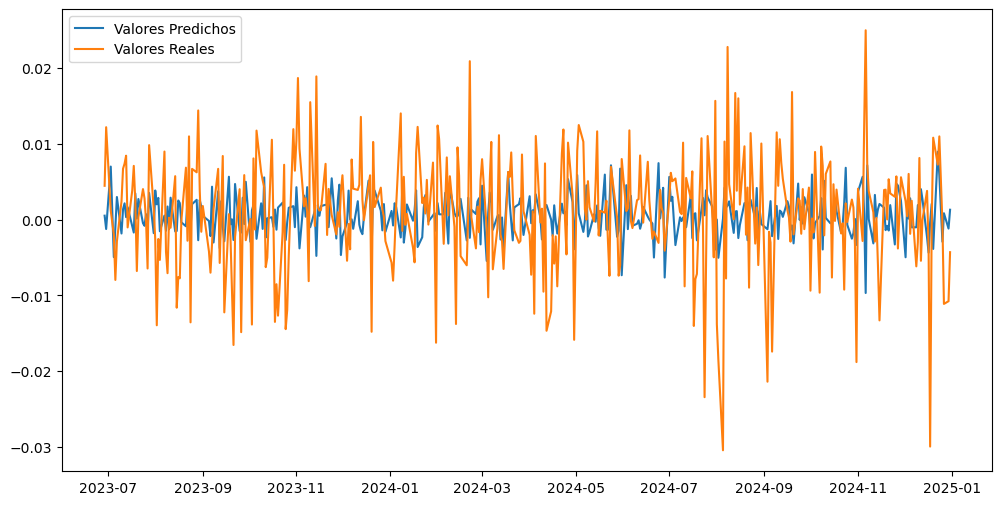

In [170]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_pred, label="Valores Predichos")
plt.plot(y_test.index, y_test, label="Valores Reales")
plt.legend()


Text(0.5, 1.0, 'Error (y_test - y_pred) a lo largo del tiempo')

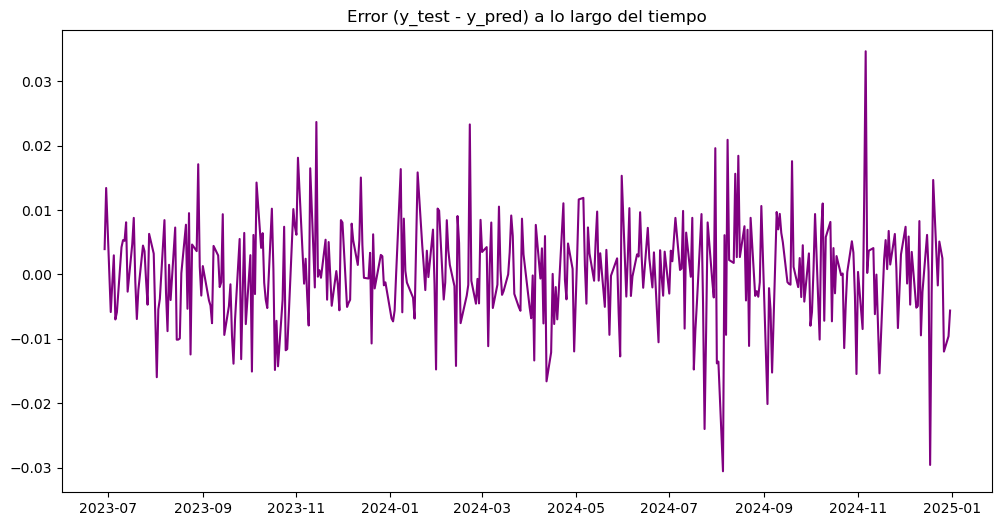

In [171]:
plt.figure(figsize=(12, 6))
plt.plot(y_test - y_pred, color="purple")
plt.title("Error (y_test - y_pred) a lo largo del tiempo")

Text(0.5, 1.0, 'Distribución de errores')

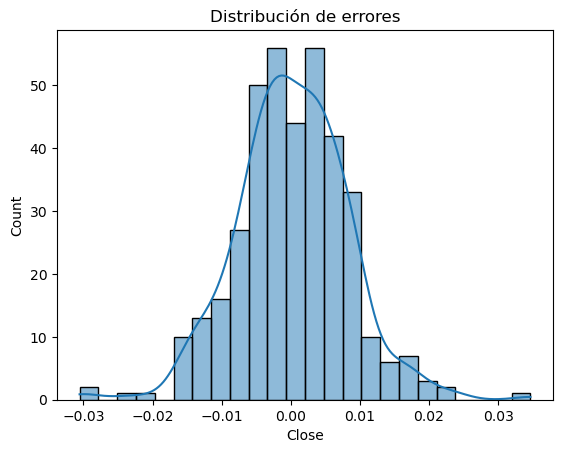

In [172]:
import seaborn as sns
sns.histplot(y_test - y_pred, kde=True)
plt.title("Distribución de errores")

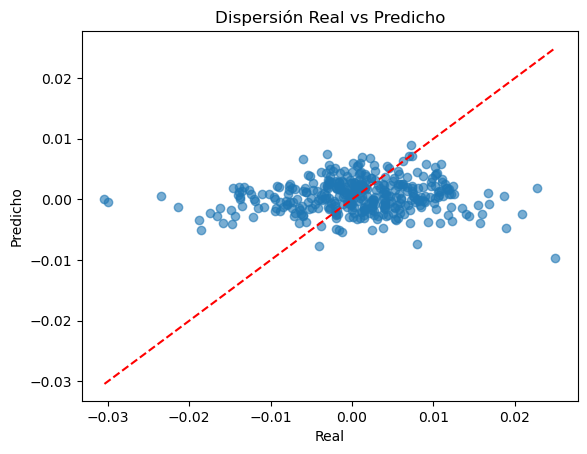

In [173]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Real")
plt.ylabel("Predicho")
plt.title("Dispersión Real vs Predicho")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')

### Modelo ARIMA

In [195]:
model_arima = ARIMA(y_train, order=(3,0,0))
fit_arima = model_arima.fit()
y_pred_arima = fit_arima.forecast(steps=len(y_test))

c:\Users\USER\anaconda3\envs\DataAnalysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\envs\DataAnalysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\envs\DataAnalysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\envs\DataAnalysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an int

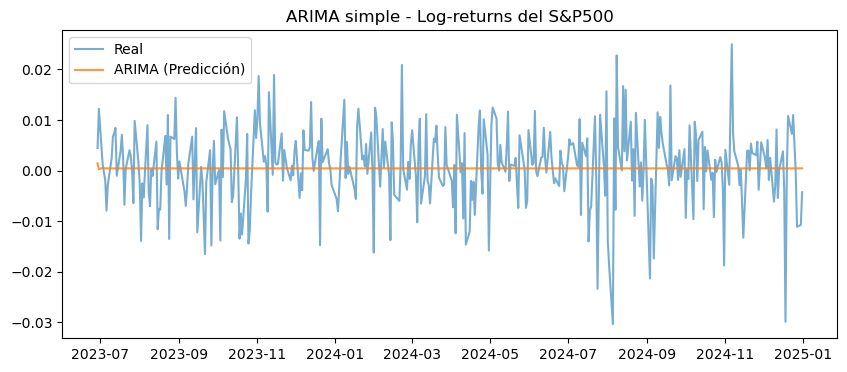

In [196]:
# Visualizamos
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test, label="Real", alpha=0.6)
plt.plot(y_test.index, y_pred_arima, label='ARIMA (Predicción)', alpha=0.8)
plt.title("ARIMA simple - Log-returns del S&P500")
plt.legend()
plt.show()

In [197]:
print(f"ARIMA - MSE: {mean_squared_error(y_test, y_pred_arima):.6f}, "
      f"R²: {r2_score(y_test, y_pred_arima):.4f}, MAE: {mean_absolute_error(y_test, y_pred_arima)}")

ARIMA - MSE: 0.000060, R²: -0.0019, MAE: 0.0058313113107594005


In [198]:
fit_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1519
Model:                 ARIMA(3, 0, 0)   Log Likelihood                4488.413
Date:                Fri, 07 Nov 2025   AIC                          -8966.827
Time:                        00:14:14   BIC                          -8940.198
Sample:                             0   HQIC                         -8956.913
                               - 1519                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.278      0.201      -0.000       0.001
ar.L1         -0.1628      0.011    -14.346      0.000      -0.185      -0.141
ar.L2          0.0806      0.011      7.244      0.000       0.059       0.102
ar.L3          0.0040      0.012      0.319      0.749      -0.020       0.028
sigma2         0.0002   2.54e-06     62.547      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              9334.68
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                            -0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelo SARIMAX (PCA)

In [200]:
n_componentes = 10
pca = PCA(n_components=n_componentes)
X_pca = pca.fit_transform(X_scaled)
X_pca = pd.DataFrame(X_pca, index=X.index, columns=[f'PC{i+1}' for i in range(n_componentes)])
explained = pca.explained_variance_ratio_
print(f"Varianza total explicada por los {n_components} componentes: {explained.sum():.2%}")

Varianza total explicada por los 10 componentes: 43.99%


In [63]:
X_SARIMAXpca_train, X_SARIMAXpca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, shuffle=False)

In [64]:
model_sarimax_pca = SARIMAX(y_train, exog=X_SARIMAXpca_train, order=(2,0,2), enforce_stationarity=False, enforce_invertibility=False)
fit_sarimax_pca = model_sarimax_pca.fit()
y_pred_sarimax_pca = fit_sarimax_pca.predict(start=len(y_train), end=len(y)-1,exog=X_SARIMAXpca_test)

c:\Users\USER\anaconda3\envs\DataAnalysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\envs\DataAnalysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\envs\DataAnalysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\USER\anaconda3\envs\DataAnalysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without

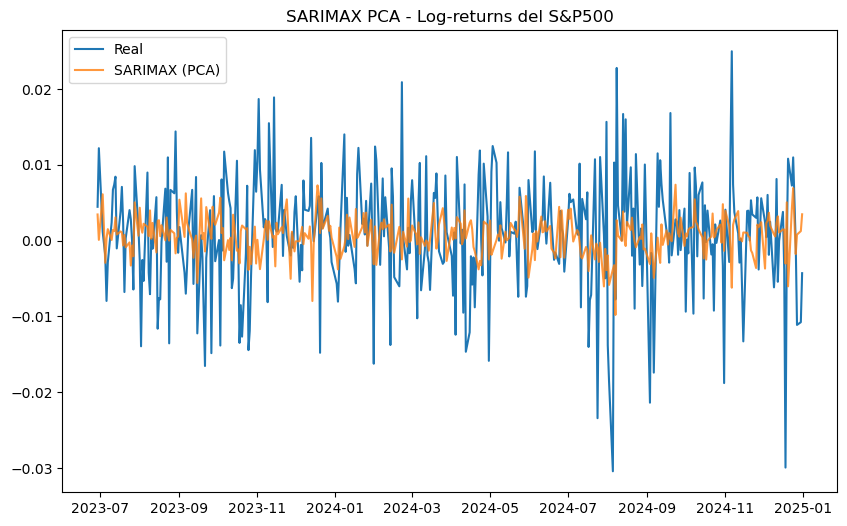

In [65]:
# Visualizamos
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, y_pred_sarimax_pca, label='SARIMAX (PCA)', alpha=0.8)
plt.title("SARIMAX PCA - Log-returns del S&P500")
plt.legend()
plt.show()

In [66]:
print(f"SARIMAX (PCA) - MSE: {mean_squared_error(y_test, y_pred_sarimax_pca):.6f}, "
      f"R²: {r2_score(y_test, y_pred_sarimax_pca):.4f}, MAE: {mean_absolute_error(y_test, y_pred_sarimax_pca)}")

SARIMAX (PCA) - MSE: 0.000062, R²: -0.0354, MAE: 0.005980686849606678


In [67]:
fit_sarimax_pca.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1519
Model:               SARIMAX(2, 0, 2)   Log Likelihood                4517.623
Date:                Thu, 06 Nov 2025   AIC                          -9005.245
Time:                        14:43:45   BIC                          -8925.388
Sample:                             0   HQIC                         -8975.511
                               - 1519                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1        -8.333e-05   1.49e-05     -5.591      0.000      -0.000   -5.41e-05
PC2            0.0001   3.39e-05      4.053      0.000    7.09e-05       0.000
PC3        -8.631e-05   3.42e-05     -2.524      0.012      -0.000   -1.93e-05
PC4           -0.0001   3.45e-05     -3.384      0.001      -0.000   -4.92e-05
PC5        -3.487e-05   3.21e-05     -1.085      0.278   -9.78e-05    2.81e-05
PC6           -0.0001   3.85e-05     -3.466      0.001      -0.000   -5.79e-05
PC7           -0.0002   4.71e-05     -3.978      0.000      -0.000    -9.5e-05
PC8            0.0002   6.07e-05      3.561      0.000    9.72e-05       0.000
PC9            0.0002   5.42e-05      3.103      0.002     6.2e-05       0.000
PC10           0.0001   5.48e-05      2.736      0.006    4.25e-05       0.000
ar.L1         -0.3354      3.224     -0.104      0.917      -6.654       5.983
ar.L2          0.4006      2.769      0.145      0.885      -5.026       5.827
ma.L1          0.3201      3.245      0.099      0.921      -6.040       6.680
ma.L2         -0.3874      2.738     -0.141      0.888      -5.754       4.980
sigma2         0.0002   3.42e-06     44.062      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):              4689.43
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Modelo SARIMAX (Con todas las features)

In [76]:
X_SARIMAX_train, X_SARIMAX_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [77]:
model_sarimax = SARIMAX(y_train, exog=X_SARIMAX_train, order=(2,0,2), enforce_stationarity=False, enforce_invertibility=False)
fit_sarimax = model_sarimax.fit()
y_pred_sarimax = fit_sarimax.predict(start=len(y_train), end=len(y)-1,exog=X_SARIMAX_test)

c:\Users\USER\anaconda3\envs\DataAnalysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\envs\DataAnalysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\anaconda3\envs\DataAnalysis\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\USER\anaconda3\envs\DataAnalysis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `sta

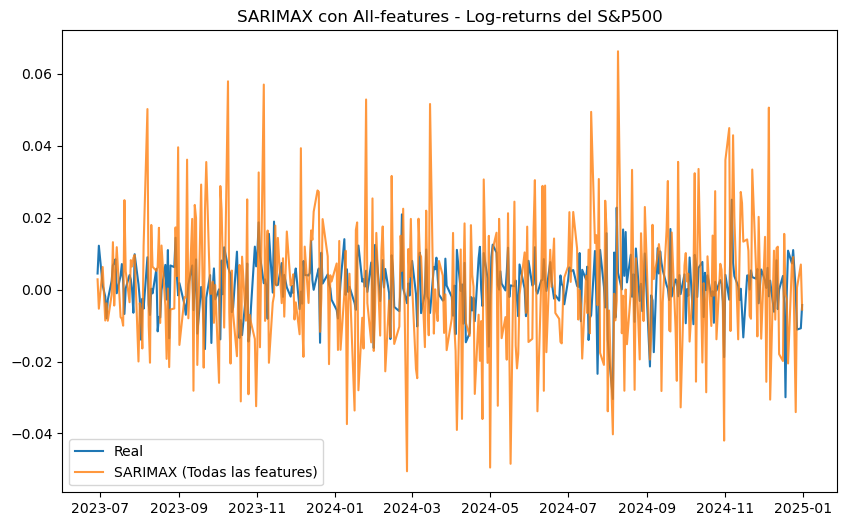

In [78]:
# Visualizamos
plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Real')
plt.plot(y_test.index, y_pred_sarimax, label='SARIMAX (Todas las features)', alpha=0.8)
plt.title("SARIMAX con All-features - Log-returns del S&P500")
plt.legend()
plt.show()

In [79]:
print(f"SARIMAX All features - MSE: {mean_squared_error(y_test, y_pred_sarimax):.6f}, "
      f"R²: {r2_score(y_test, y_pred_sarimax):.4f}, MAE: {mean_absolute_error(y_test, y_pred_sarimax)}")


SARIMAX All features - MSE: 0.000385, R²: -5.4109, MAE: 0.015515237267785788


In [80]:
fit_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1519
Model:               SARIMAX(2, 0, 2)   Log Likelihood               16069.705
Date:                Thu, 06 Nov 2025   AIC                         -27373.410
Time:                        15:01:16   BIC                         -14686.722
Sample:                             0   HQIC                        -22649.668
                               - 1519                                         
Covariance Type:                  opg                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
A_High-Low-Spread        -0.0243      0.000    -99.319      0.000      -0.025      -0.024
A_Log-Returns_t-1         0.0046      0.000     10.730      0.000       0.004       0.005
A_Log-Returns_t-2        -0.0257      0.000    -63.226      0.000      -0.027      -0.025
A_Log-Returns_t-3         0.0199      0.000     50.545      0.000       0.019       0.021
A_Volume-Change          -0.0009   6.26e-05    -13.839      0.000      -0.001      -0.001
AAPL_High-Low-Spread     -0.0180      0.000    -56.062      0.000      -0.019      -0.017
AAPL_Log-Returns_t-1     -0.0252      0.000    -54.926      0.000      -0.026      -0.024
AAPL_Log-Returns_t-2     -0.0610      0.000   -143.619      0.000      -0.062      -0.060
AAPL_Log-Returns_t-3     -0.0126      0.000    -27.298      0.000      -0.013      -0.012
AAPL_Volume-Change       -0.0008    9.1e-05     -8.909      0.000      -0.001      -0.001
ABBV_High-Low-Spread     -0.0131      0.000    -31.396      0.000      -0.014      -0.012
ABBV_Log-Returns_t-1      0.0073      0.001     13.831      0.000       0.006       0.008
ABBV_Log-Returns_t-2     -0.0123      0.001    -23.205      0.000      -0.013      -0.011
ABBV_Log-Returns_t-3      0.0025      0.000      4.943      0.000       0.001       0.003
ABBV_Volume-Change       -0.0016   6.39e-05    -25.721      0.000      -0.002      -0.002
ABT_High-Low-Spread      -0.0322      0.000   -103.349      0.000      -0.033      -0.032
ABT_Log-Returns_t-1      -0.0270      0.000    -63.973      0.000      -0.028      -0.026
ABT_Log-Returns_t-2      -0.0111      0.000    -29.545      0.000      -0.012      -0.010
ABT_Log-Returns_t-3      -0.0650      0.000   -143.967      0.000      -0.066      -0.064
ABT_Volume-Change         0.0006   7.33e-05      7.720      0.000       0.000       0.001
ACGL_High-Low-Spread     -0.0144      0.000    -38.817      0.000      -0.015      -0.014
ACGL_Log-Returns_t-1     -0.0354      0.000    -80.424      0.000      -0.036      -0.035
ACGL_Log-Returns_t-2     -0.0145      0.000    -35.920      0.000      -0.015      -0.014
ACGL_Log-Returns_t-3      0.0048      0.000     10.628      0.000       0.004       0.006
ACGL_Volume-Change        0.0012   5.18e-05     23.640      0.000       0.001       0.001
ACN_High-Low-Spread       0.0103      0.000     34.959      0.000       0.010       0.011
ACN_Log-Returns_t-1      -0.0042      0.000    -11.122      0.000      -0.005      -0.003
ACN_Log-Returns_t-2      -0.0221      0.000    -56.051      0.000      -0.023      -0.021
ACN_Log-Returns_t-3      -0.0209      0.000    -51.861      0.000      -0.022      -0.020
ACN_Volume-Change         0.0001   7.81e-05      1.591      0.112   -2.88e-05       0.000
ADBE_High-Low-Spread     -0.0061      0.000    -17.791      0.000      -0.007      -0.005
ADBE_Log-Returns_t-1      0.0509      0.000    106.062      0.000       0.050       0.052
ADBE_Log-Returns_t-2     -0.0169      0.000    -35.197      0.000      -0.018      -0.016
A

### Modelo Random Forest Regressor 

In [184]:
rfr = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': [100, 200, 400, 600, 800],
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rfr_random_search = RandomizedSearchCV(
    estimator=rfr,
    param_distributions=param_dist,
    n_iter=50,
    scoring=scorer,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

rfr_random_search.fit(X_train, y_train)

rfr_model = rf_random_search.best_estimator_
y_pred = best_rf.predict(X_test)

In [ ]:
print(f"Random Forest Regressor - MSE: {mean_squared_error(y_test, y_pred_rfr):.6f}, "
      f"R²: {r2_score(y_test, y_pred_rfr):.4f}, MAE: {mean_absolute_error(y_test, y_pred_rfr)}")

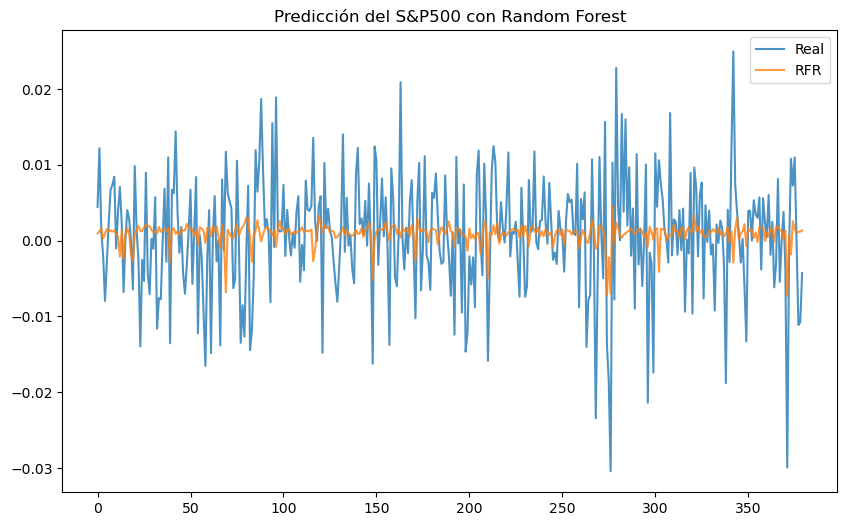

In [88]:
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Real', alpha=0.8)
plt.plot(y_pred_rfr, label='RFR', alpha=0.8)
plt.legend()
plt.title("Predicción del S&P500 con Random Forest")
plt.show()


### Analisis de features y stocks

In [139]:
importances = pd.Series(rfr_model.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False, inplace=True)

log_ret_1_importances = importances.xs('Log-Returns_t-1', level=1)
log_ret_2_importances = importances.xs('Log-Returns_t-2', level=1)
log_ret_3_importances = importances.xs('Log-Returns_t-3', level=1)
high_low_spread_importances = importances.xs("High-Low-Spread", level=1)
volume_change_importances = importances.xs("Volume-Change", level=1)
scores = (importances.groupby(level=0).sum().sort_values(ascending=False))

N = 20
ranking_df = pd.DataFrame({
    "Log Returns t-1 (ticker)": log_ret_1_importances.sort_values(ascending=False).head(N).index,
    "Log Returns t-1 (val)": log_ret_1_importances.sort_values(ascending=False).head(N).values,
    "Log Returns t-2 (ticker)": log_ret_2_importances.sort_values(ascending=False).head(N).index,
    "Log Returns t-2 (val)": log_ret_2_importances.sort_values(ascending=False).head(N).values,
    "Log Returns t-3 (ticker)": log_ret_3_importances.sort_values(ascending=False).head(N).index,
    "Log Returns t-3 (val)": log_ret_3_importances.sort_values(ascending=False).head(N).values,
    "High Low Spread (ticker)": high_low_spread_importances.sort_values(ascending=False).head(N).index,
    "High Low Spread (val)": high_low_spread_importances.sort_values(ascending=False).head(N).values,
    "Volume Change (ticker)": volume_change_importances.sort_values(ascending=False).head(N).index,
    "Volume Change (val)": volume_change_importances.sort_values(ascending=False).head(N).values,
    "Score Total (ticker)": scores.sort_values(ascending=False).head(N).index,
    "Score Total (val)": scores.sort_values(ascending=False).head(N).values
})
ranking_df

,Log Returns t-1 (ticker),Log Returns t-1 (val),Log Returns t-2 (ticker),Log Returns t-2 (val),Log Returns t-3 (ticker),Log Returns t-3 (val),High Low Spread (ticker),High Low Spread (val),Volume Change (ticker),Volume Change (val),Score Total (ticker),Score Total (val)
0,EG,0.010303,APTV,0.007455,AMGN,0.005205,MSFT,0.040688,MMC,0.001621,MSFT,0.041285
1,PNW,0.010286,PH,0.005320,SO,0.003637,WTW,0.030254,PEP,0.001500,WTW,0.030726
2,RJF,0.006658,AMGN,0.003669,OXY,0.003037,EMN,0.022166,KO,0.001360,EMN,0.022733
3,DIS,0.005413,WELL,0.003089,APA,0.002902,APH,0.015476,JPM,0.001339,APH,0.016656
4,ATO,0.004831,PSA,0.002975,D,0.002859,PEP,0.011331,UHS,0.001273,PNW,0.013495
5,KMI,0.004609,WEC,0.002904,AEP,0.002595,CSCO,0.011009,ICE,0.001212,PEP,0.013182
6,ACGL,0.003166,EXR,0.002647,CTRA,0.002377,ACN,0.009829,SBUX,0.001127,EG,0.011573
7,ES,0.002871,WRB,0.002334,DVN,0.001806,GM,0.006932,EFX,0.001099,CSCO,0.011312
8,HPQ,0.002666,IR,0.002292,LUV,0.001688,NCLH,0.006661,FI,0.001050,APTV,0.010717
9,EXC,0.002270,EXPD,0.002073,LNT,0.001364,MPC,0.006588,MS,0.001025,ACN,0.010039
